In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
data=np.load("C:\\Users\\Pranshu\\Desktop\\mariel_betternot_and_retrograde.npy",allow_pickle=True)
print(data.shape)

(55, 10925, 3)


In [5]:
print(data[:4,0])

[[-1.39662576 -3.73199248 -1.60784531]
 [-1.39639997 -3.95945549 -1.35652041]
 [-1.35178769 -3.78872967 -1.28920305]
 [-1.15556657 -3.69554257 -0.07362488]]


In [83]:
from glob import glob
from tqdm import tqdm
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import juggle_axes
from IPython.display import display, HTML
import matplotlib.pyplot as plt
ffmpeg_path = "C:\\Users\\Pranshu\\ffmpeg-7.1.1-essentials_build\\ffmpeg-7.1.1-essentials_build\\bin\\ffmpeg.exe"
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path


point_labels = [
    'pelvis', 'left_hip', 'right_hip',      # 2
    'spine1', 'left_knee', 'right_knee',    # 5
    'spine2', 'left_ankle', 'right_ankle',  # 8
    'spine3', 'left_foot', 'right_foot',    # 11
    'neck', 'left_collar', 'right_collar',  # 14
    'jaw',                                  # 15
    'left_shoulder', 'right_shoulder',      # 17
    'left_elbow', 'right_elbow',            # 19
    'left_wrist', 'right_wrist',            # 21
    'left_thumb', 'right_thumb',
    'head', 'left_middle', 'right_middle',  # 26
    'left_bigtoe', 'right_bigtoe'
]

skeleton_lines = [
    #  ( (start group), (end group) ),
    (('pelvis',), ('left_hip',)),
    (('pelvis',), ('right_hip',)),
    (('left_hip',), ('left_knee',)), 
    (('right_hip',), ('right_knee',)),
    (('left_knee',), ('left_ankle',)), 
    (('right_knee',), ('right_ankle',)),
    (('left_ankle',), ('left_foot',)),
    (('right_ankle',), ('right_foot',)),
    (('pelvis',), ('spine1',)), 
    (('spine1',), ('spine2',)),
    (('spine2',), ('spine3',)),
    (('spine3',), ('neck',)),
    (('spine3',), ('left_collar',)),
    (('spine3',), ('right_collar',)),
    (('neck',), ('jaw',)),
    (('left_collar',), ('left_shoulder',)),
    (('right_collar',), ('right_shoulder',)),
    (('left_shoulder',), ('left_elbow',)),
    (('right_shoulder',), ('right_elbow',)),
    (('left_elbow',), ('left_wrist',)),
    (('right_elbow',), ('right_wrist',)),
    (('left_wrist',), ('left_thumb',)),
    (('right_wrist',), ('right_thumb',)),
    (('neck',), ('head',)),
    
    # (('left_shoulder',), ('left_middle',)),
    # (('right_shoulder',), ('right_middle',)),
    (('left_ankle',), ('left_bigtoe',)),
    (('right_ankle',), ('right_bigtoe',)),
]


skeleton_idxs = []
for g1, g2 in skeleton_lines:
    entry = []
    entry.append([point_labels.index(l) for l in g1])
    entry.append([point_labels.index(l) for l in g2])
    skeleton_idxs.append(entry)

# Cloud of every point connected:
cloud_idxs = []
for i in range(29):
    for j in range(29):
        entry = []
        entry.append([i])
        entry.append([j])
        cloud_idxs.append(entry)

all_idxs = skeleton_idxs + cloud_idxs

def get_line_segments(seq, zcolor=None, cmap=None, cloud=False, edge_types=None, edge_class=None):
    xline = np.zeros((seq.shape[0], len(all_idxs), 3, 2))
    if cmap:
        colors = np.zeros((len(all_idxs), 4))
    for edge, (joint1, joint2) in enumerate(all_idxs):
        xline[:, edge, :,0] = np.mean(seq[:, joint1], axis=1)
        xline[:, edge, :,1] = np.mean(seq[:, joint2], axis=1)    
        if cmap:
            if edge_types is not None:
                if edge >= len(skeleton_idxs): # cloud edges
                    if edge_types[edge - len(skeleton_idxs), edge_class] == 1:
                        colors[edge] = cmap(1)
                    else:
                        colors[edge] = cmap(0)
            else:
                colors[edge] = cmap(0)
    if cmap:
        return xline, colors
    else:
        return xline

# put line segments on the given axis, with given colors
def put_lines(ax, segments, color=None, lw=2.5, alpha=None, skeleton=True, skeleton_alpha=0.3, cloud=False, cloud_alpha=0.03, threshold=0, edge_types=None, edge_opacities=None, edge_class=None):
    lines = []
    ### Main skeleton
    for i in tqdm(range(len(skeleton_idxs)), desc="Skeleton lines"):
        if isinstance(color, (list, tuple, np.ndarray)):
            c = color[i]
        else:
            c = color
                        
        if skeleton: alpha = skeleton_alpha
        else: alpha = 0
            
        ### THESE LINES PLOT THE MAIN SKELETON
        l = ax.plot(np.linspace(segments[i, 0, 0],segments[i, 0, 1], 2),
                np.linspace(segments[i, 1, 0], segments[i, 1, 1], 2),
                np.linspace(segments[i, 2, 0], segments[i, 2, 1], 2),
                # color=c,
                alpha=alpha,
                lw=lw)[0]
        lines.append(l)
    
    if cloud:
        ### Cloud of all-connected joints
        for i in tqdm(range(len(cloud_idxs)), desc="Cloud lines"):
            if isinstance(color, (list, tuple, np.ndarray)):
                c = color[i]
            else:
                c = color
                
            l = ax.plot(
                np.linspace(segments[i, 0, 0], segments[i, 0, 1], 2),
                np.linspace(segments[i, 1, 0], segments[i, 1, 1], 2),
                np.linspace(segments[i, 2, 0], segments[i, 2, 1], 2),
                color=c,
                alpha=cloud_alpha,
                lw=lw)[0]
            lines.append(l)
    return lines

# animate a video of the stick figure.
# `ghost` may be a second sequence, which will be superimposed on the primary sequence.
# If ghost_shift is given, the primary and ghost sequence will be separated laterally by that amount.
# `zcolor` may be an N-length array, where N is the number of vertices in seq, and will be used to color the vertices. Typically this is set to the avg. z-value of each vtx.
def animate_stick(seq, ghost=None, ghost_shift=0, threshold=0, figsize=None, zcolor=None, pointer=None, ax_lims=(-1.0, 1.0), speed=45, dot_size=20, dot_alpha=0.5, lw=2.5, cmap='cool_r', pointer_color='black', cloud=False, cloud_alpha=0.03, skeleton=True, skeleton_alpha=0.3):
    if zcolor is None:
        zcolor = np.zeros(seq.shape[1])
    
    fig = plt.figure(figsize=figsize)
    # ax = p3.Axes3D(fig)
    ax = plt.axes(projection='3d')
    ax.view_init(elev=180, azim=90)
    
    # The following lines eliminate background lines/axes:
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    # ax.set_frame_on(True)
    
    # set figure background opacity (alpha) to 0:
    fig.patch.set_alpha(0.)
    
    if ghost_shift and ghost is not None:
        seq = seq.copy()
        ghost = ghost.copy()
        seq[:, :, 0] -= ghost_shift
        ghost[:, :, 0] += ghost_shift
    
    cm = matplotlib.colormaps[cmap]

    dot_color = "black"
    pts = ax.scatter(seq[0, :, 0], seq[0, :, 1], seq[0, :, 2], c=dot_color, s=dot_size, alpha=dot_alpha)
    ghost_color = 'blue'

    if ghost is not None:
        pts_g = ax.scatter(ghost[0, :, 0], ghost[0, :, 1], ghost[0, :, 2], c=ghost_color, s=dot_size, alpha=dot_alpha)
    
    if ax_lims:
        ax.set_xlim(*ax_lims)
        ax.set_ylim(*ax_lims)
        ax.set_zlim(*ax_lims)

    plt.close(fig)
    xline, colors = get_line_segments(seq, zcolor, cm)
    lines = put_lines(ax, xline[0], color=colors, lw=lw, alpha=0.9, cloud=cloud, cloud_alpha=cloud_alpha, threshold=threshold, skeleton=skeleton, skeleton_alpha=skeleton_alpha)
    
    if ghost is not None:
        xline_g = get_line_segments(ghost)
        lines_g = put_lines(ax, xline_g[0], ghost_color, lw=lw, alpha=1.0, cloud=cloud, cloud_alpha=cloud_alpha, skeleton=skeleton, skeleton_alpha=skeleton_alpha)
    
    if pointer is not None:
        vR = 0.15
        dX, dY = vR * np.cos(pointer), vR * np.sin(pointer)
        zidx = point_labels.index('CLAV')
        X = seq[:, zidx, 0]
        Y = seq[:, zidx, 1]
        Z = seq[:, zidx, 2]
        quiv = ax.quiver(X[0], Y[0], Z[0], dX[0], dY[0], 0, color=pointer_color)
        ax.quiv = quiv
    
    def update(t):
        pts._offsets3d = juggle_axes(seq[t, :, 0], seq[t, :, 1], seq[t, :, 2], 'z')
        for i,l in enumerate(lines):
            if l is not None:
                l.set_data(xline[t, i, :2])
                l.set_3d_properties(xline[t, i, 2])
        
        if ghost is not None:
            pts_g._offsets3d = juggle_axes(ghost[t, :, 0], ghost[t, :, 1], ghost[t, :, 2], 'z')
            for i, l in enumerate(lines_g):
                l.set_data(xline_g[t, i, :2])
                l.set_3d_properties(xline_g[t, i, 2])
        
        if pointer is not None:
            ax.quiv.remove()
            ax.quiv = ax.quiver(X[t], Y[t], Z[t], dX[t], dY[t], 0, color=pointer_color)
    
    return animation.FuncAnimation(
        fig,
        update,
        len(seq),
        interval=speed,
        blit=False,
    )

In [79]:
seq = np.transpose(data, (1, 0, 2))  # Shape (n_frames, n_joints, 3)

In [84]:
plt.rcParams['animation.embed_limit'] = 500
# Animate
ani = animate_stick(seq, figsize=(8,6))
HTML(ani.to_jshtml()) 
ani.save('skeleton_animation.mp4', writer='ffmpeg', fps=30)
from IPython.display import Video
Video('skeleton_animation.mp4')

Skeleton lines: 100%|████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1128.14it/s]


In [7]:
data1=data.transpose(1,0,2)
data1.shape

(10925, 55, 3)

In [85]:
seq=data1
seq_length=30
clips = [seq[i:i+seq_length] for i in range (0,len(seq)-seq_length,seq_length)]


In [86]:
features=np.mean(np.mean(np.abs(np.diff(clips,axis=1)),axis=1),axis=2)


In [10]:
clips[0].shape

(30, 55, 3)

In [11]:
features.shape

(364, 55)

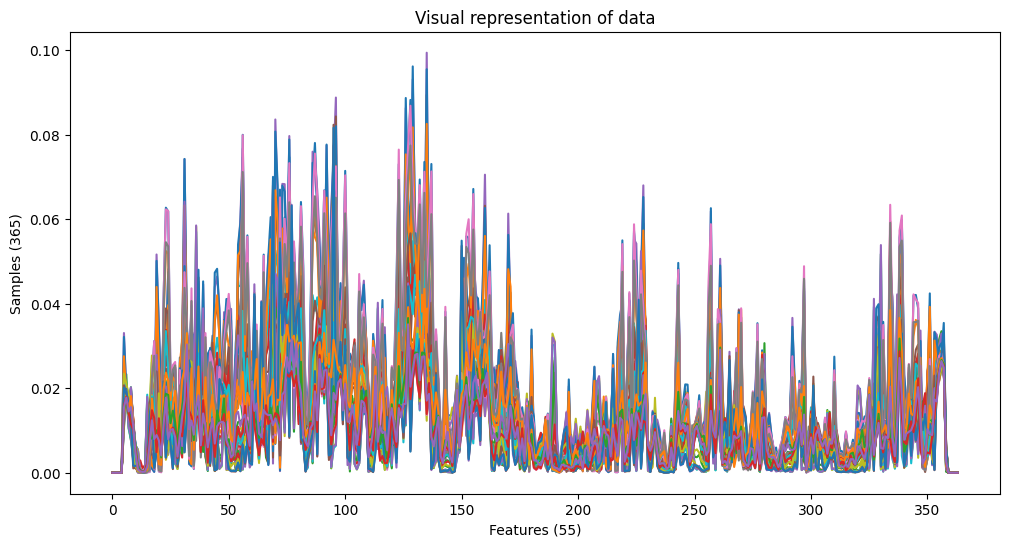

In [94]:
import matplotlib.pyplot as plt
import numpy as np
data = features  
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.xlabel("Features (55)")
plt.ylabel("Samples (365)")
plt.title("Visual representation of data")
plt.show()

In [87]:
import pandas as pd
df = pd.DataFrame(features, columns=[f'Joint_{i+1}' for i in range(features.shape[1])])

In [88]:
df[184:190]

,Joint_1,Joint_2,Joint_3,Joint_4,Joint_5,Joint_6,Joint_7,Joint_8,Joint_9,Joint_10,...,Joint_46,Joint_47,Joint_48,Joint_49,Joint_50,Joint_51,Joint_52,Joint_53,Joint_54,Joint_55
184,0.002419,0.002458,0.003616,0.003171,0.002591,0.003254,0.002202,0.009435,0.002819,0.008641,...,0.007433,0.006936,0.006844,0.007716,0.004537,0.007467,0.006157,0.003009,0.001043,0.001804
185,0.004814,0.003592,0.005749,0.005866,0.004544,0.003572,0.002561,0.005301,0.005265,0.005251,...,0.008074,0.007055,0.006824,0.005266,0.006966,0.008946,0.006523,0.005029,0.003130,0.003516
186,0.010542,0.009805,0.008841,0.003256,0.009888,0.008481,0.003660,0.003419,0.010620,0.002663,...,0.002666,0.011569,0.011703,0.003013,0.004353,0.003311,0.012590,0.006275,0.003478,0.007080
187,0.009476,0.003664,0.002999,0.002451,0.006317,0.003562,0.001883,0.001629,0.008852,0.001098,...,0.000469,0.013822,0.012332,0.000713,0.001144,0.000619,0.004828,0.002354,0.001876,0.003172
188,0.004923,0.005168,0.004856,0.006433,0.003793,0.005145,0.006906,0.008257,0.005832,0.008355,...,0.002847,0.004401,0.004281,0.003535,0.004383,0.001322,0.004860,0.005793,0.006021,0.006268
189,0.004251,0.001410,0.002076,0.019535,0.002652,0.002799,0.001981,0.002607,0.003714,0.001703,...,0.003510,0.001585,0.001472,0.003043,0.001222,0.002703,0.000798,0.002208,0.001847,0.001664


In [89]:
X_labeled=df[0:99]
y_labeled=pd.read_csv("C:\\Users\\Pranshu\\Downloads\\Book 12(Sheet1) (2).csv")

In [16]:
y_labeled

,Movements,Unnamed: 1
0,No Movement,NaN
1,No Movement,NaN
2,No Movement,NaN
3,No Movement,NaN
4,No Movement,NaN
...,...,...
112,NaN,NaN
113,NaN,NaN
114,NaN,NaN
115,NaN,NaN


In [90]:
X_unlabeled=df[99:365]
X_unlabeled

,Joint_1,Joint_2,Joint_3,Joint_4,Joint_5,Joint_6,Joint_7,Joint_8,Joint_9,Joint_10,...,Joint_46,Joint_47,Joint_48,Joint_49,Joint_50,Joint_51,Joint_52,Joint_53,Joint_54,Joint_55
99,0.016694,0.014854,0.018647,0.023246,0.016632,0.018284,0.017206,0.033085,0.017607,0.033684,...,0.011462,0.045170,0.039841,0.014645,0.018789,0.012478,0.019193,0.018579,0.015559,0.014744
100,0.020053,0.020489,0.020647,0.018148,0.019765,0.019932,0.019162,0.023064,0.019988,0.023414,...,0.031603,0.070408,0.061405,0.028680,0.023254,0.030113,0.025483,0.019799,0.018534,0.021013
101,0.010158,0.010903,0.011503,0.030596,0.010182,0.009792,0.012973,0.010466,0.009934,0.011280,...,0.003430,0.039920,0.036367,0.006584,0.009094,0.003700,0.016848,0.011561,0.011925,0.012087
102,0.009825,0.012098,0.010898,0.000879,0.009739,0.011922,0.009181,0.017863,0.009066,0.020176,...,0.003748,0.018306,0.016494,0.005285,0.007660,0.002607,0.015451,0.009495,0.005322,0.012067
103,0.010244,0.013274,0.013225,0.016167,0.010466,0.013540,0.015389,0.024134,0.013578,0.023836,...,0.010517,0.025936,0.025204,0.010750,0.012185,0.010539,0.020921,0.013908,0.013554,0.015907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
y_labeled = y_labeled.drop(columns=["Unnamed: 1"], errors='ignore')

In [19]:
y_labeled=y_labeled.dropna(subset=["Movements"])
y_labeled

,Movements
0,No Movement
1,No Movement
2,No Movement
3,No Movement
4,No Movement
...,...
94,Spinning
95,Spinning
96,Spinning
97,Walking


In [18]:
y_labeled

,Movements
0,No Movement
1,No Movement
2,No Movement
3,No Movement
4,No Movement
...,...
112,NaN
113,NaN
114,NaN
115,NaN


In [23]:
print("y_labeled indices:", y_labeled.index)

y_labeled indices: RangeIndex(start=0, stop=117, step=1)


In [21]:
k=14
k_means =KMeans(n_clusters=k, random_state=42)
k_means.fit(X_labeled)

y_unlabeled=k_means.predict(X_unlabeled)

from scipy.spatial.distance import cdist
cluster_centers=k_means.cluster_centers_
closest_labels=[]
for center in cluster_centers:
    closest_idx=np.argmin(cdist([center],X_labeled))
    closest_labels.append(y_labeled.iloc[closest_idx])
final_labels = [closest_labels[cluster] for cluster in y_unlabeled]

C:\Users\Pranshu\anaconda3\envs\notebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
y_unlabeled

array([13,  0, 13, 11,  2,  2, 11,  6, 13, 13, 13, 11,  1, 11, 11,  7, 11,
       11,  7,  7,  7, 11,  7, 11, 12, 13, 13, 12,  8,  3,  3, 12,  8, 12,
        8, 12, 12,  8,  6, 11,  2,  7,  1,  1, 11,  1,  1,  1, 11,  2, 11,
        0,  5,  6,  6,  6, 12, 13, 13, 13,  8, 12,  0, 13, 11, 11,  7,  7,
        2, 11, 11,  4, 13, 13, 11,  7,  1, 11,  1, 11,  1,  7,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  7,  1,  1,  1,  7, 11,  1,  1,  2,  1,  7,
       13,  6,  1, 11,  4,  2,  6,  6,  0, 13, 13, 13,  1,  1,  1,  7,  1,
        1,  1,  1,  1,  1,  1,  1, 11,  3, 11, 11,  7, 11,  1,  1, 11, 11,
       11,  1,  1,  1, 11, 12,  7,  1, 13, 12,  1,  1,  1,  7,  1, 11, 11,
        4, 11,  1,  1,  1,  1, 11,  1, 11,  1,  2,  7,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, 11,  1,  7,  2, 11,  6,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [20]:
y_labeled1 = np.array(y_labeled, dtype=str)
unique=np.unique(y_labeled1)
print(unique)

['Arm Raising' 'Bending' 'Body Roll' 'Crotch Grab' 'Floor Rocking'
 'Hand Movement' 'Hands Fold' 'Lifting' 'No Movement' 'Sliding' 'Spinning'
 'Stretching Legs' 'Twisting' 'Walking']


In [24]:
y_unlabeled.shape

(265,)

In [23]:
label_mapping={0:"Walking",1:"No Movement",2:"Twisting",3:"Body Roll",4:"Lifting",5:"Hand Movement",6:"Bending",7:"Floor Rocking",8:"Spinning",9:"Crotch Grab",10:"Sliding",11:"Hands Fold",12:"Stretching Legs",13:"Arm Raising"}

In [55]:
unique, counts = np.unique(y_unlabeled, return_counts=True)
# Print frequency
for num, freq in zip(unique, counts):
    print(f"Number {num}: {freq} times")

Number 0: 8 times
Number 1: 115 times
Number 2: 15 times
Number 3: 3 times
Number 4: 6 times
Number 5: 1 times
Number 6: 9 times
Number 7: 26 times
Number 8: 6 times
Number 11: 44 times
Number 12: 12 times
Number 13: 20 times


In [25]:
label_array = np.vectorize(label_mapping.get)(y_unlabeled)
# Print sample output
print(label_array[:10])

['Arm Raising' 'Walking' 'Arm Raising' 'Hands Fold' 'Twisting' 'Twisting'
 'Hands Fold' 'Bending' 'Arm Raising' 'Arm Raising']


In [26]:
df_y_unlabeled=pd.DataFrame(label_array,columns=["Movements"])

In [27]:
y=pd.concat([y_labeled, df_y_unlabeled],ignore_index=True)
y

,Movements
0,No Movement
1,No Movement
2,No Movement
3,No Movement
4,No Movement
...,...
359,No Movement
360,No Movement
361,No Movement
362,No Movement


In [28]:
data3 = seq.reshape(10925, 55 * 3)  # Now shape: (10925, 165)

# Split into sequences of 30 timesteps
num_samples = 364  # Adjust as needed
X= data3[:num_samples * 30].reshape(num_samples, 30, 55 * 3)

In [29]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y) 
num_classes = len(encoder.classes_)

C:\Users\Pranshu\anaconda3\envs\notebook\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
from tensorflow.keras.utils import to_categorical

y_onehot = to_categorical(y_encoded, num_classes=num_classes)
print(y_onehot.shape)

(364, 14)


In [31]:
X_train,y_train=X[:300],y_onehot[:300]
X_val,y_val=X[300:320],y_onehot[300:320]
X_test,y_test=X[320:],y_onehot[320:]
X_train.shape,y_train.shape

((300, 30, 165), (300, 14))

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model1=Sequential()
model1.add(InputLayer((30,165)))
model1.add(LSTM(128))
model1.add(Dropout(0.4))
model1.add(Dense(64,'relu'))
model1.add(Dropout(0.3))
model1.add(Dense(num_classes,activation='softmax'))

model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 128)                 │         150,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,694 (623.80 KB)

 Trainable params: 159,694 (623.80 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:

model1.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [66]:
model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1401 - loss: 2.6414 - val_accuracy: 0.9500 - val_loss: 1.0591
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3372 - loss: 2.2390 - val_accuracy: 0.9500 - val_loss: 0.7239
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3617 - loss: 2.1372 - val_accuracy: 0.9500 - val_loss: 0.8747
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3332 - loss: 2.0460 - val_accuracy: 0.9500 - val_loss: 0.9725
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3515 - loss: 1.9726 - val_accuracy: 0.9500 - val_loss: 0.7202
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4192 - loss: 1.9085 - val_accuracy: 0.9500 - val_loss: 0.9945
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3968 - loss: 1.8244 - val_accuracy: 0.9500 - val_loss: 0.8801
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4084 - loss: 1.8426 - val_accuracy: 0.

In [76]:
pred_data=model1.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [77]:
pred_labels=np.argmax(pred_data,axis=1)
print(pred_labels)

[ 8  6  8  6  6  6  1 13 11 11  0  0  0  0 11  0 11 11  0  1  0  1 12  8
  8 10  4  0  0  0 10  4  6  4  1 13  8  8  8  8  8  8  8  8]


In [98]:
y_test = np.argmax(y_test, axis=1)  # Convert (44, 14) -> (44,)

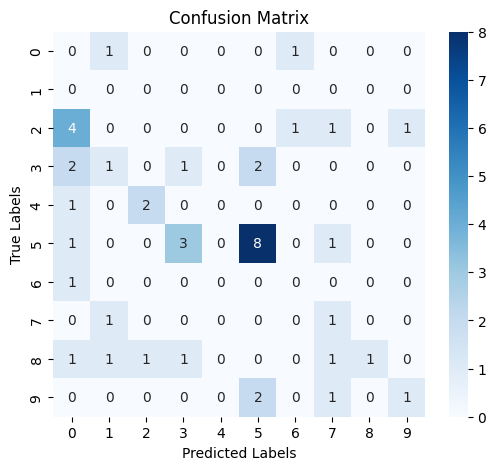

In [99]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = y_test 
y_pred = pred_labels 
 
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
